# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

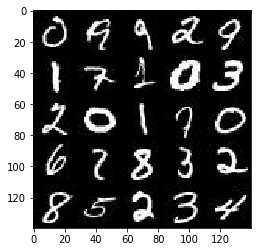

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

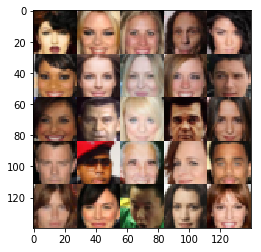

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate=tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    # The constant used in the leaky ReLU activation function.
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # The discriminator uses the DCGAN architecture. Batch normalization is
        # used on all layers except the first convolutional layer and the output layer.
        # Shape of images: 28x28x3 (CelebA) or 28x28x1 (MNIST)
        
        # First convolutional layer.
        # Resulting shape: 14x14x64
        x1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=(5,5), strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)  # Leaky ReLU
        
        # Second convolutional layer.
        # Resulting shape: 7x7x128
        x2 = tf.layers.conv2d(x1, 128, (5,5), 2, 'same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # Third convolutional layer.
        # Note: According to the TensorFlow documentation, a ceiling operator
        # is applied to the output width and height when using SAME padding.
        # That's why the width and height of 7 are downscaled to 4.
        # See https://www.tensorflow.org/api_guides/python/nn#Convolution.
        # Resulting shape: 4x4x256
        x3 = tf.layers.conv2d(x2, 256, (5,5), 2, 'same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(inputs=flat, units=1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # The constant used in the leaky ReLU activation function.
    alpha = 0.2
    
    # Only reuse variables if we're not training the network.
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # Fully connected layer.
        # Resulting shape: 7x7x512
        x1 = tf.layers.dense(inputs=z, units=7*7*512, activation=None)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)  # Leaky ReLU
        
        # First convolutional layer.
        # Resulting shape: 14x14x256
        x2 = tf.layers.conv2d_transpose(inputs=x1, filters=256, kernel_size=(5, 5), strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
                
        # Second convolutional layer.
        # Resulting shape: 28x28x128
        x3 = tf.layers.conv2d_transpose(x2, 128, (5, 5), 2, 'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer.
        # Resulting shape: 28x28x3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, (5, 5), 1, 'same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Wether or not to use label smoothing.
    use_label_smoothing = True
    
    # The label smoothing factor used to help the discriminator generalize better.
    smooth = 0.1

    # The generator output.
    g_model = generator(input_z, out_channel_dim, is_train=True)

    # The discriminator output and logits when fed the real and fake images.
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate the discriminator loss.
    # ---------------------------------
    # For real images, the labels are all ones (because they are the real images).
    if use_label_smoothing:
        d_labels_real = tf.ones_like(d_model_real) * (1 - smooth)
    else:
        d_labels_real = tf.ones_like(d_model_real)
    d_cross_entropy_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real)
    d_loss_real = tf.reduce_mean(d_cross_entropy_real)
    
    # For fake images, the labels are all zeros (because they are the fake images).
    d_lables_fake = tf.zeros_like(d_model_fake) * (1 - smooth)
    d_cross_entroy_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_lables_fake)
    d_loss_fake = tf.reduce_mean(d_cross_entroy_fake)
    
    # Calculate the total loss.
    d_loss = d_loss_real + d_loss_fake
    
    # Calculate the generator loss.
    # -----------------------------
    # Remember, the generator is trying to fool the discriminator into outputting
    # ones for fake images. That's why the labels are set to all ones for the fake output.
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and biases to update, separately for the discriminator and the generator.
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Run the optimizer on the respective discriminator and generator variables.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    print("data_shape={}".format(data_shape))
    print("data_image_mode={}".format(data_image_mode))
    
    # saver = tf.train.Saver()
    
    # Build the model.
    # ----------------
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    # Train the model.
    # ----------------
    batch_i = 0
    losses = []
    n_images = 25
    show_losses_every = 10
    show_output_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_i += 1
                
                # Rescale images from (-0.5, 0.5) to (-1, 1), because we're using the
                # tanh activation function in the generator which has a range of (-1, 1).
                batch_images = batch_images * 2

                # Sample random noise for the generator.
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run the optimizers on both the discriminator and the generator.
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                # Note_ We need to pass the values for the placeholders 'input_real'
                # and 'lr' here to satisfy TensorFlow. They aren't actually used.
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                # Print losses every 25 batches.
                if batch_i % show_losses_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Batch {}...".format(batch_i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    # Save losses to view after training.
                    losses.append((train_loss_d, train_loss_g))

                # Print generator output every 100 batches.
                if batch_i % show_output_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    
            print("Batches per epoch: {}".format(batch_i))    
            
        show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
        # saver.save(sess, './checkpoints/generator.ckpt')
    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

data_shape=(60000, 28, 28, 1)
data_image_mode=L
Epoch 1/2... Batch 10... Discriminator Loss: 0.3777... Generator Loss: 7.1991
Epoch 1/2... Batch 20... Discriminator Loss: 0.3418... Generator Loss: 5.0034
Epoch 1/2... Batch 30... Discriminator Loss: 0.3562... Generator Loss: 5.9184
Epoch 1/2... Batch 40... Discriminator Loss: 0.7746... Generator Loss: 1.7261
Epoch 1/2... Batch 50... Discriminator Loss: 0.8555... Generator Loss: 3.5622
Epoch 1/2... Batch 60... Discriminator Loss: 0.6038... Generator Loss: 3.3608
Epoch 1/2... Batch 70... Discriminator Loss: 0.7701... Generator Loss: 2.0437
Epoch 1/2... Batch 80... Discriminator Loss: 0.5067... Generator Loss: 2.5129
Epoch 1/2... Batch 90... Discriminator Loss: 1.0690... Generator Loss: 2.2485
Epoch 1/2... Batch 100... Discriminator Loss: 0.9759... Generator Loss: 1.3990


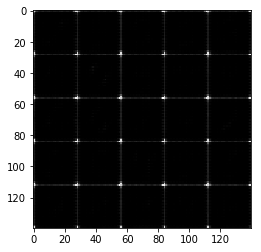

Epoch 1/2... Batch 110... Discriminator Loss: 1.0701... Generator Loss: 0.8910
Epoch 1/2... Batch 120... Discriminator Loss: 0.8780... Generator Loss: 1.7716
Epoch 1/2... Batch 130... Discriminator Loss: 1.3102... Generator Loss: 0.6845
Epoch 1/2... Batch 140... Discriminator Loss: 1.1019... Generator Loss: 1.2149
Epoch 1/2... Batch 150... Discriminator Loss: 1.3109... Generator Loss: 0.8271
Epoch 1/2... Batch 160... Discriminator Loss: 0.9821... Generator Loss: 1.4919
Epoch 1/2... Batch 170... Discriminator Loss: 1.0240... Generator Loss: 0.9024
Epoch 1/2... Batch 180... Discriminator Loss: 1.0496... Generator Loss: 1.2984
Epoch 1/2... Batch 190... Discriminator Loss: 1.1886... Generator Loss: 1.3229
Epoch 1/2... Batch 200... Discriminator Loss: 1.3001... Generator Loss: 1.8367


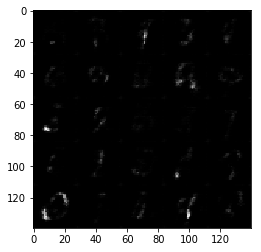

Epoch 1/2... Batch 210... Discriminator Loss: 1.2823... Generator Loss: 0.6343
Epoch 1/2... Batch 220... Discriminator Loss: 1.2128... Generator Loss: 1.3852
Epoch 1/2... Batch 230... Discriminator Loss: 1.1909... Generator Loss: 1.7195
Epoch 1/2... Batch 240... Discriminator Loss: 1.0826... Generator Loss: 1.4241
Epoch 1/2... Batch 250... Discriminator Loss: 1.2722... Generator Loss: 0.5940
Epoch 1/2... Batch 260... Discriminator Loss: 0.9548... Generator Loss: 1.3583
Epoch 1/2... Batch 270... Discriminator Loss: 1.0090... Generator Loss: 0.9281
Epoch 1/2... Batch 280... Discriminator Loss: 1.0492... Generator Loss: 0.9081
Epoch 1/2... Batch 290... Discriminator Loss: 1.0110... Generator Loss: 1.4425
Epoch 1/2... Batch 300... Discriminator Loss: 1.0989... Generator Loss: 0.9602


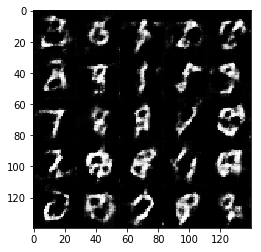

Epoch 1/2... Batch 310... Discriminator Loss: 1.1654... Generator Loss: 2.2207
Epoch 1/2... Batch 320... Discriminator Loss: 0.9554... Generator Loss: 1.2208
Epoch 1/2... Batch 330... Discriminator Loss: 1.2619... Generator Loss: 1.9661
Epoch 1/2... Batch 340... Discriminator Loss: 1.1325... Generator Loss: 0.8400
Epoch 1/2... Batch 350... Discriminator Loss: 1.0313... Generator Loss: 1.0637
Epoch 1/2... Batch 360... Discriminator Loss: 1.2737... Generator Loss: 0.6281
Epoch 1/2... Batch 370... Discriminator Loss: 1.1804... Generator Loss: 0.7123
Epoch 1/2... Batch 380... Discriminator Loss: 1.0889... Generator Loss: 1.2425
Epoch 1/2... Batch 390... Discriminator Loss: 1.1855... Generator Loss: 0.7260
Epoch 1/2... Batch 400... Discriminator Loss: 1.0686... Generator Loss: 1.5027


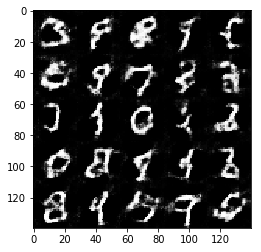

Epoch 1/2... Batch 410... Discriminator Loss: 1.0846... Generator Loss: 1.0360
Epoch 1/2... Batch 420... Discriminator Loss: 1.0612... Generator Loss: 1.0784
Epoch 1/2... Batch 430... Discriminator Loss: 1.0812... Generator Loss: 0.8396
Epoch 1/2... Batch 440... Discriminator Loss: 1.1083... Generator Loss: 1.6226
Epoch 1/2... Batch 450... Discriminator Loss: 1.1241... Generator Loss: 0.8533
Epoch 1/2... Batch 460... Discriminator Loss: 1.0856... Generator Loss: 1.0993
Batches per epoch: 468
Epoch 2/2... Batch 470... Discriminator Loss: 1.0273... Generator Loss: 1.8182
Epoch 2/2... Batch 480... Discriminator Loss: 1.0357... Generator Loss: 1.4792
Epoch 2/2... Batch 490... Discriminator Loss: 1.4395... Generator Loss: 2.1292
Epoch 2/2... Batch 500... Discriminator Loss: 1.0511... Generator Loss: 1.4449


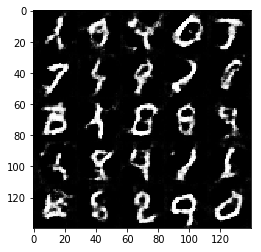

Epoch 2/2... Batch 510... Discriminator Loss: 1.0183... Generator Loss: 1.2358
Epoch 2/2... Batch 520... Discriminator Loss: 1.1732... Generator Loss: 0.6964
Epoch 2/2... Batch 530... Discriminator Loss: 1.0623... Generator Loss: 0.8429
Epoch 2/2... Batch 540... Discriminator Loss: 1.2071... Generator Loss: 1.9100
Epoch 2/2... Batch 550... Discriminator Loss: 1.1194... Generator Loss: 1.2793
Epoch 2/2... Batch 560... Discriminator Loss: 1.0363... Generator Loss: 1.3032
Epoch 2/2... Batch 570... Discriminator Loss: 1.1435... Generator Loss: 0.7978
Epoch 2/2... Batch 580... Discriminator Loss: 1.0924... Generator Loss: 1.1428
Epoch 2/2... Batch 590... Discriminator Loss: 1.0905... Generator Loss: 0.8531
Epoch 2/2... Batch 600... Discriminator Loss: 1.0435... Generator Loss: 0.9568


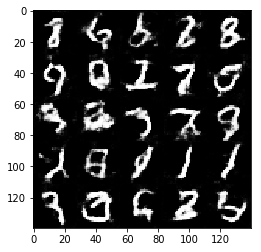

Epoch 2/2... Batch 610... Discriminator Loss: 1.1320... Generator Loss: 1.5012
Epoch 2/2... Batch 620... Discriminator Loss: 1.0925... Generator Loss: 1.2343
Epoch 2/2... Batch 630... Discriminator Loss: 1.0568... Generator Loss: 0.9405
Epoch 2/2... Batch 640... Discriminator Loss: 1.0094... Generator Loss: 1.1530
Epoch 2/2... Batch 650... Discriminator Loss: 1.2609... Generator Loss: 0.5723
Epoch 2/2... Batch 660... Discriminator Loss: 1.0608... Generator Loss: 0.8964
Epoch 2/2... Batch 670... Discriminator Loss: 1.0483... Generator Loss: 0.9083
Epoch 2/2... Batch 680... Discriminator Loss: 1.0305... Generator Loss: 1.3459
Epoch 2/2... Batch 690... Discriminator Loss: 0.9900... Generator Loss: 1.3023
Epoch 2/2... Batch 700... Discriminator Loss: 1.8704... Generator Loss: 2.6859


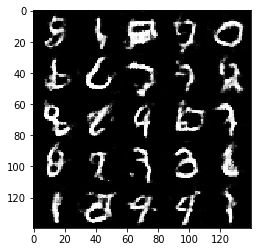

Epoch 2/2... Batch 710... Discriminator Loss: 0.9855... Generator Loss: 1.2432
Epoch 2/2... Batch 720... Discriminator Loss: 1.0140... Generator Loss: 1.0683
Epoch 2/2... Batch 730... Discriminator Loss: 0.8962... Generator Loss: 1.5181
Epoch 2/2... Batch 740... Discriminator Loss: 0.9571... Generator Loss: 1.1458
Epoch 2/2... Batch 750... Discriminator Loss: 0.9919... Generator Loss: 0.8628
Epoch 2/2... Batch 760... Discriminator Loss: 0.9836... Generator Loss: 0.9569
Epoch 2/2... Batch 770... Discriminator Loss: 1.0036... Generator Loss: 1.1651
Epoch 2/2... Batch 780... Discriminator Loss: 1.0351... Generator Loss: 0.9647
Epoch 2/2... Batch 790... Discriminator Loss: 1.0219... Generator Loss: 1.4249
Epoch 2/2... Batch 800... Discriminator Loss: 0.9482... Generator Loss: 1.0053


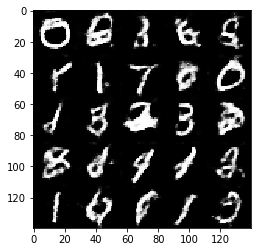

Epoch 2/2... Batch 810... Discriminator Loss: 1.0564... Generator Loss: 1.0707
Epoch 2/2... Batch 820... Discriminator Loss: 1.0221... Generator Loss: 0.9621
Epoch 2/2... Batch 830... Discriminator Loss: 1.0995... Generator Loss: 0.7131
Epoch 2/2... Batch 840... Discriminator Loss: 0.8931... Generator Loss: 1.0942
Epoch 2/2... Batch 850... Discriminator Loss: 1.8395... Generator Loss: 2.5238
Epoch 2/2... Batch 860... Discriminator Loss: 1.0691... Generator Loss: 0.8847
Epoch 2/2... Batch 870... Discriminator Loss: 0.9960... Generator Loss: 1.0645
Epoch 2/2... Batch 880... Discriminator Loss: 0.9726... Generator Loss: 1.4492
Epoch 2/2... Batch 890... Discriminator Loss: 0.9416... Generator Loss: 1.1283
Epoch 2/2... Batch 900... Discriminator Loss: 1.2970... Generator Loss: 2.1070


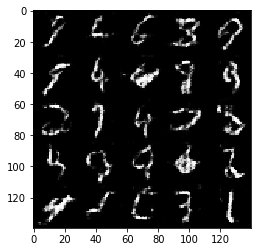

Epoch 2/2... Batch 910... Discriminator Loss: 1.0398... Generator Loss: 0.8824
Epoch 2/2... Batch 920... Discriminator Loss: 1.0221... Generator Loss: 0.9807
Epoch 2/2... Batch 930... Discriminator Loss: 0.9743... Generator Loss: 1.2787
Batches per epoch: 936


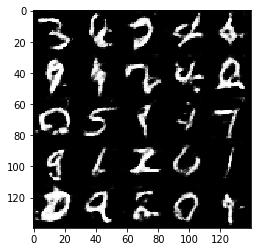

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses_mnist = train(epochs, batch_size, z_dim, learning_rate, beta1, 
                         mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)

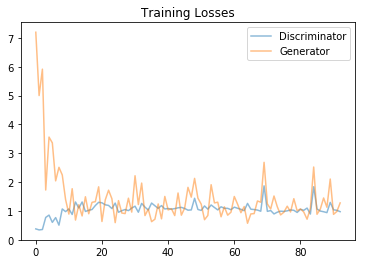

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

losses_mnist = np.array(losses_mnist)
plt.plot(losses_mnist.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses_mnist.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data_shape=(202599, 28, 28, 3)
data_image_mode=RGB
Epoch 1/1... Batch 10... Discriminator Loss: 0.6828... Generator Loss: 1.8910
Epoch 1/1... Batch 20... Discriminator Loss: 0.5403... Generator Loss: 2.5842
Epoch 1/1... Batch 30... Discriminator Loss: 0.6482... Generator Loss: 1.8399
Epoch 1/1... Batch 40... Discriminator Loss: 2.2798... Generator Loss: 5.0948
Epoch 1/1... Batch 50... Discriminator Loss: 1.0076... Generator Loss: 1.4320
Epoch 1/1... Batch 60... Discriminator Loss: 1.0112... Generator Loss: 1.5740
Epoch 1/1... Batch 70... Discriminator Loss: 1.0589... Generator Loss: 1.8465
Epoch 1/1... Batch 80... Discriminator Loss: 0.9275... Generator Loss: 1.0955
Epoch 1/1... Batch 90... Discriminator Loss: 0.6838... Generator Loss: 1.7529
Epoch 1/1... Batch 100... Discriminator Loss: 1.4324... Generator Loss: 5.9303


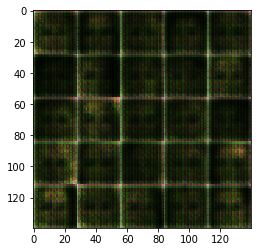

Epoch 1/1... Batch 110... Discriminator Loss: 1.0954... Generator Loss: 0.7752
Epoch 1/1... Batch 120... Discriminator Loss: 0.9750... Generator Loss: 4.9036
Epoch 1/1... Batch 130... Discriminator Loss: 0.8580... Generator Loss: 1.0754
Epoch 1/1... Batch 140... Discriminator Loss: 0.6180... Generator Loss: 2.9098
Epoch 1/1... Batch 150... Discriminator Loss: 0.6307... Generator Loss: 1.6087
Epoch 1/1... Batch 160... Discriminator Loss: 0.7601... Generator Loss: 1.2566
Epoch 1/1... Batch 170... Discriminator Loss: 0.9117... Generator Loss: 1.0745
Epoch 1/1... Batch 180... Discriminator Loss: 0.6565... Generator Loss: 1.6003
Epoch 1/1... Batch 190... Discriminator Loss: 0.7470... Generator Loss: 1.3358
Epoch 1/1... Batch 200... Discriminator Loss: 0.9838... Generator Loss: 0.8319


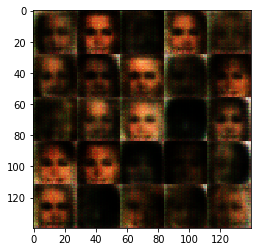

Epoch 1/1... Batch 210... Discriminator Loss: 0.5545... Generator Loss: 3.4821
Epoch 1/1... Batch 220... Discriminator Loss: 1.0859... Generator Loss: 1.0649
Epoch 1/1... Batch 230... Discriminator Loss: 0.9562... Generator Loss: 3.0719
Epoch 1/1... Batch 240... Discriminator Loss: 0.8817... Generator Loss: 2.1664
Epoch 1/1... Batch 250... Discriminator Loss: 1.5278... Generator Loss: 0.4527
Epoch 1/1... Batch 260... Discriminator Loss: 1.0127... Generator Loss: 1.0791
Epoch 1/1... Batch 270... Discriminator Loss: 1.5337... Generator Loss: 4.3645
Epoch 1/1... Batch 280... Discriminator Loss: 1.5324... Generator Loss: 0.4621
Epoch 1/1... Batch 290... Discriminator Loss: 1.0036... Generator Loss: 1.4351
Epoch 1/1... Batch 300... Discriminator Loss: 1.0704... Generator Loss: 0.9647


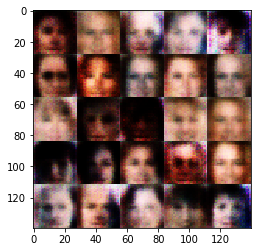

Epoch 1/1... Batch 310... Discriminator Loss: 0.7337... Generator Loss: 1.7966
Epoch 1/1... Batch 320... Discriminator Loss: 0.7566... Generator Loss: 1.4992
Epoch 1/1... Batch 330... Discriminator Loss: 0.8900... Generator Loss: 1.7465
Epoch 1/1... Batch 340... Discriminator Loss: 1.2816... Generator Loss: 1.6473
Epoch 1/1... Batch 350... Discriminator Loss: 0.8417... Generator Loss: 1.6686
Epoch 1/1... Batch 360... Discriminator Loss: 1.3589... Generator Loss: 0.5688
Epoch 1/1... Batch 370... Discriminator Loss: 0.7387... Generator Loss: 3.6493
Epoch 1/1... Batch 380... Discriminator Loss: 1.2167... Generator Loss: 0.6966
Epoch 1/1... Batch 390... Discriminator Loss: 0.8790... Generator Loss: 1.2056
Epoch 1/1... Batch 400... Discriminator Loss: 0.7320... Generator Loss: 1.3074


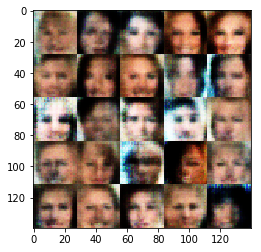

Epoch 1/1... Batch 410... Discriminator Loss: 1.5835... Generator Loss: 0.5152
Epoch 1/1... Batch 420... Discriminator Loss: 1.2672... Generator Loss: 0.6050
Epoch 1/1... Batch 430... Discriminator Loss: 1.2039... Generator Loss: 0.8353
Epoch 1/1... Batch 440... Discriminator Loss: 0.8931... Generator Loss: 1.1802
Epoch 1/1... Batch 450... Discriminator Loss: 1.0993... Generator Loss: 1.1472
Epoch 1/1... Batch 460... Discriminator Loss: 0.7097... Generator Loss: 2.6334
Epoch 1/1... Batch 470... Discriminator Loss: 0.6502... Generator Loss: 1.4869
Epoch 1/1... Batch 480... Discriminator Loss: 0.7236... Generator Loss: 1.4954
Epoch 1/1... Batch 490... Discriminator Loss: 0.7551... Generator Loss: 4.4489
Epoch 1/1... Batch 500... Discriminator Loss: 1.2624... Generator Loss: 0.6163


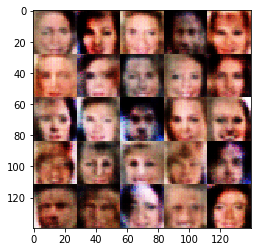

Epoch 1/1... Batch 510... Discriminator Loss: 0.8304... Generator Loss: 1.3060
Epoch 1/1... Batch 520... Discriminator Loss: 2.0194... Generator Loss: 0.8819
Epoch 1/1... Batch 530... Discriminator Loss: 1.0607... Generator Loss: 2.0322
Epoch 1/1... Batch 540... Discriminator Loss: 1.3586... Generator Loss: 3.6765
Epoch 1/1... Batch 550... Discriminator Loss: 1.1986... Generator Loss: 2.0392
Epoch 1/1... Batch 560... Discriminator Loss: 1.4887... Generator Loss: 0.4208
Epoch 1/1... Batch 570... Discriminator Loss: 0.7304... Generator Loss: 1.6666
Epoch 1/1... Batch 580... Discriminator Loss: 0.6930... Generator Loss: 1.7639
Epoch 1/1... Batch 590... Discriminator Loss: 0.5717... Generator Loss: 2.8882
Epoch 1/1... Batch 600... Discriminator Loss: 0.7915... Generator Loss: 2.6165


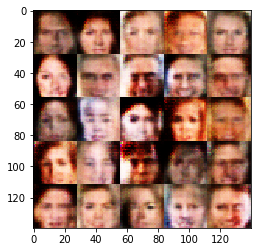

Epoch 1/1... Batch 610... Discriminator Loss: 0.5997... Generator Loss: 1.7354
Epoch 1/1... Batch 620... Discriminator Loss: 0.8893... Generator Loss: 1.0365
Epoch 1/1... Batch 630... Discriminator Loss: 0.5007... Generator Loss: 2.7856
Epoch 1/1... Batch 640... Discriminator Loss: 0.6833... Generator Loss: 1.5170
Epoch 1/1... Batch 650... Discriminator Loss: 1.2872... Generator Loss: 0.5467
Epoch 1/1... Batch 660... Discriminator Loss: 0.5701... Generator Loss: 2.4714
Epoch 1/1... Batch 670... Discriminator Loss: 0.9462... Generator Loss: 0.9068
Epoch 1/1... Batch 680... Discriminator Loss: 0.5900... Generator Loss: 1.7223
Epoch 1/1... Batch 690... Discriminator Loss: 0.7797... Generator Loss: 3.8367
Epoch 1/1... Batch 700... Discriminator Loss: 0.5619... Generator Loss: 6.1448


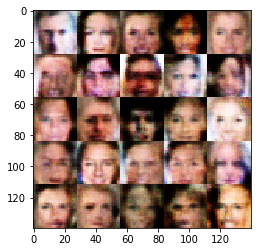

Epoch 1/1... Batch 710... Discriminator Loss: 0.4830... Generator Loss: 5.1347
Epoch 1/1... Batch 720... Discriminator Loss: 0.4200... Generator Loss: 3.1828
Epoch 1/1... Batch 730... Discriminator Loss: 0.7911... Generator Loss: 1.1367
Epoch 1/1... Batch 740... Discriminator Loss: 0.5407... Generator Loss: 2.3980
Epoch 1/1... Batch 750... Discriminator Loss: 0.6409... Generator Loss: 1.9434
Epoch 1/1... Batch 760... Discriminator Loss: 1.0783... Generator Loss: 0.7277
Epoch 1/1... Batch 770... Discriminator Loss: 0.4959... Generator Loss: 2.5368
Epoch 1/1... Batch 780... Discriminator Loss: 0.6772... Generator Loss: 2.6062
Epoch 1/1... Batch 790... Discriminator Loss: 0.9987... Generator Loss: 0.8167
Epoch 1/1... Batch 800... Discriminator Loss: 0.5096... Generator Loss: 3.0402


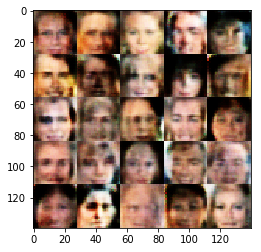

Epoch 1/1... Batch 810... Discriminator Loss: 0.9486... Generator Loss: 0.8888
Epoch 1/1... Batch 820... Discriminator Loss: 0.6004... Generator Loss: 1.6988
Epoch 1/1... Batch 830... Discriminator Loss: 0.5110... Generator Loss: 2.0663
Epoch 1/1... Batch 840... Discriminator Loss: 0.6573... Generator Loss: 1.5445
Epoch 1/1... Batch 850... Discriminator Loss: 0.4426... Generator Loss: 2.5390
Epoch 1/1... Batch 860... Discriminator Loss: 0.5184... Generator Loss: 2.9576
Epoch 1/1... Batch 870... Discriminator Loss: 0.5742... Generator Loss: 1.7164
Epoch 1/1... Batch 880... Discriminator Loss: 0.9018... Generator Loss: 1.7751
Epoch 1/1... Batch 890... Discriminator Loss: 0.6096... Generator Loss: 1.5917
Epoch 1/1... Batch 900... Discriminator Loss: 0.6270... Generator Loss: 3.5656


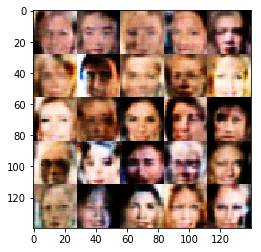

Epoch 1/1... Batch 910... Discriminator Loss: 0.6993... Generator Loss: 1.3992
Epoch 1/1... Batch 920... Discriminator Loss: 0.7132... Generator Loss: 1.3489
Epoch 1/1... Batch 930... Discriminator Loss: 0.5014... Generator Loss: 2.1291
Epoch 1/1... Batch 940... Discriminator Loss: 0.4592... Generator Loss: 2.3880
Epoch 1/1... Batch 950... Discriminator Loss: 0.4339... Generator Loss: 4.5464
Epoch 1/1... Batch 960... Discriminator Loss: 0.4654... Generator Loss: 2.3112
Epoch 1/1... Batch 970... Discriminator Loss: 0.8406... Generator Loss: 1.0712
Epoch 1/1... Batch 980... Discriminator Loss: 0.9601... Generator Loss: 1.4682
Epoch 1/1... Batch 990... Discriminator Loss: 0.6231... Generator Loss: 1.6236
Epoch 1/1... Batch 1000... Discriminator Loss: 0.3910... Generator Loss: 4.6317


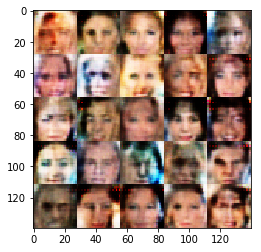

Epoch 1/1... Batch 1010... Discriminator Loss: 1.2340... Generator Loss: 4.4398
Epoch 1/1... Batch 1020... Discriminator Loss: 0.4849... Generator Loss: 2.6615
Epoch 1/1... Batch 1030... Discriminator Loss: 0.5027... Generator Loss: 2.1193
Epoch 1/1... Batch 1040... Discriminator Loss: 0.5070... Generator Loss: 2.0828
Epoch 1/1... Batch 1050... Discriminator Loss: 0.8116... Generator Loss: 1.3462
Epoch 1/1... Batch 1060... Discriminator Loss: 0.5971... Generator Loss: 3.0391
Epoch 1/1... Batch 1070... Discriminator Loss: 0.4752... Generator Loss: 4.1858
Epoch 1/1... Batch 1080... Discriminator Loss: 0.4393... Generator Loss: 3.0680
Epoch 1/1... Batch 1090... Discriminator Loss: 0.4402... Generator Loss: 4.3983
Epoch 1/1... Batch 1100... Discriminator Loss: 0.3775... Generator Loss: 4.8781


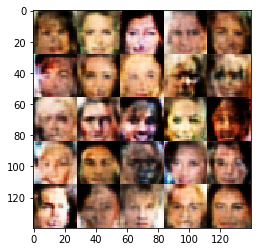

Epoch 1/1... Batch 1110... Discriminator Loss: 0.4595... Generator Loss: 2.5296
Epoch 1/1... Batch 1120... Discriminator Loss: 0.4659... Generator Loss: 2.4100
Epoch 1/1... Batch 1130... Discriminator Loss: 1.8128... Generator Loss: 0.3869
Epoch 1/1... Batch 1140... Discriminator Loss: 0.6349... Generator Loss: 1.9224
Epoch 1/1... Batch 1150... Discriminator Loss: 0.4444... Generator Loss: 3.7958
Epoch 1/1... Batch 1160... Discriminator Loss: 0.4468... Generator Loss: 4.3868
Epoch 1/1... Batch 1170... Discriminator Loss: 0.9959... Generator Loss: 2.1908
Epoch 1/1... Batch 1180... Discriminator Loss: 0.3989... Generator Loss: 3.4927
Epoch 1/1... Batch 1190... Discriminator Loss: 0.4233... Generator Loss: 3.0468
Epoch 1/1... Batch 1200... Discriminator Loss: 0.5346... Generator Loss: 1.9623


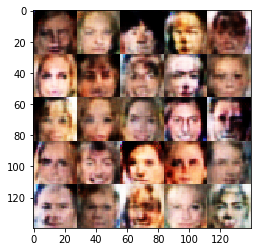

Epoch 1/1... Batch 1210... Discriminator Loss: 0.9668... Generator Loss: 3.9764
Epoch 1/1... Batch 1220... Discriminator Loss: 0.6178... Generator Loss: 1.9233
Epoch 1/1... Batch 1230... Discriminator Loss: 0.7177... Generator Loss: 1.3737
Epoch 1/1... Batch 1240... Discriminator Loss: 0.5465... Generator Loss: 1.9188
Epoch 1/1... Batch 1250... Discriminator Loss: 0.5352... Generator Loss: 2.0097
Epoch 1/1... Batch 1260... Discriminator Loss: 0.4766... Generator Loss: 2.6093
Epoch 1/1... Batch 1270... Discriminator Loss: 0.7584... Generator Loss: 2.8327
Epoch 1/1... Batch 1280... Discriminator Loss: 0.5644... Generator Loss: 1.8308
Epoch 1/1... Batch 1290... Discriminator Loss: 0.7186... Generator Loss: 1.5148
Epoch 1/1... Batch 1300... Discriminator Loss: 0.4096... Generator Loss: 3.1497


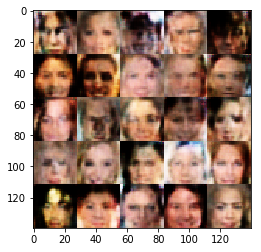

Epoch 1/1... Batch 1310... Discriminator Loss: 0.5859... Generator Loss: 3.6480
Epoch 1/1... Batch 1320... Discriminator Loss: 0.8886... Generator Loss: 0.9913
Epoch 1/1... Batch 1330... Discriminator Loss: 0.7375... Generator Loss: 4.1744
Epoch 1/1... Batch 1340... Discriminator Loss: 0.4405... Generator Loss: 2.9734
Epoch 1/1... Batch 1350... Discriminator Loss: 0.6392... Generator Loss: 3.8492
Epoch 1/1... Batch 1360... Discriminator Loss: 0.5268... Generator Loss: 3.6665
Epoch 1/1... Batch 1370... Discriminator Loss: 1.8562... Generator Loss: 3.3760
Epoch 1/1... Batch 1380... Discriminator Loss: 0.5224... Generator Loss: 2.4154
Epoch 1/1... Batch 1390... Discriminator Loss: 0.5893... Generator Loss: 2.5329
Epoch 1/1... Batch 1400... Discriminator Loss: 1.0556... Generator Loss: 0.7491


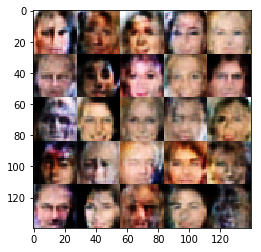

Epoch 1/1... Batch 1410... Discriminator Loss: 0.4865... Generator Loss: 2.4721
Epoch 1/1... Batch 1420... Discriminator Loss: 0.4950... Generator Loss: 2.6641
Epoch 1/1... Batch 1430... Discriminator Loss: 0.3872... Generator Loss: 3.6846
Epoch 1/1... Batch 1440... Discriminator Loss: 0.4696... Generator Loss: 2.5485
Epoch 1/1... Batch 1450... Discriminator Loss: 0.4867... Generator Loss: 3.9921
Epoch 1/1... Batch 1460... Discriminator Loss: 0.5117... Generator Loss: 2.6849
Epoch 1/1... Batch 1470... Discriminator Loss: 0.6105... Generator Loss: 1.6058
Epoch 1/1... Batch 1480... Discriminator Loss: 0.5931... Generator Loss: 3.1944
Epoch 1/1... Batch 1490... Discriminator Loss: 0.3707... Generator Loss: 4.0882
Epoch 1/1... Batch 1500... Discriminator Loss: 0.8134... Generator Loss: 1.1552


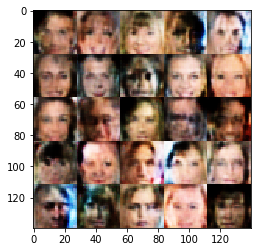

Epoch 1/1... Batch 1510... Discriminator Loss: 1.7600... Generator Loss: 2.7688
Epoch 1/1... Batch 1520... Discriminator Loss: 0.5887... Generator Loss: 2.2426
Epoch 1/1... Batch 1530... Discriminator Loss: 0.9860... Generator Loss: 1.5717
Epoch 1/1... Batch 1540... Discriminator Loss: 0.6367... Generator Loss: 1.5464
Epoch 1/1... Batch 1550... Discriminator Loss: 0.5403... Generator Loss: 2.4286
Epoch 1/1... Batch 1560... Discriminator Loss: 0.4792... Generator Loss: 4.4241
Epoch 1/1... Batch 1570... Discriminator Loss: 0.6410... Generator Loss: 4.4427
Epoch 1/1... Batch 1580... Discriminator Loss: 0.4749... Generator Loss: 2.3062
Batches per epoch: 1582


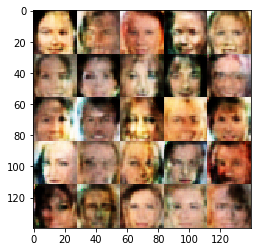

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses_celeba = train(epochs, batch_size, z_dim, learning_rate, beta1,
                          celeba_dataset.get_batches, celeba_dataset.shape, celeba_dataset.image_mode)

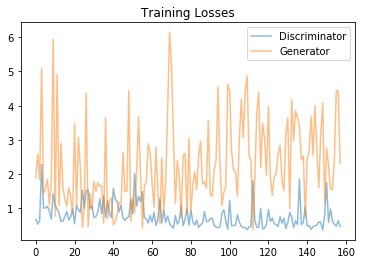

In [15]:
losses_celeba = np.array(losses_celeba)
plt.plot(losses_celeba.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses_celeba.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.